# Lab 3: Forecasting Competition - Predicting Gold Price
<img src="https://internationalbanker.com/wp-content/uploads/2021/12/Gold-Prices.png" alt="Drawing" style="width: 300px;"/>

## Instructions
<hr>

rubric={mechanics:5}

You will receive marks for correctly submitting this assignment. To submit this assignment you should:
1. Push your assignment to your GitHub repository. **Paste URL here**
2. Upload the lab `.ipynb` file to Gradescope. 
3. Double check if all the plots are rendered properly on Gradescope and the autograder returns your score.
4. If your notebook is too heavy to be rendered on Gradescope, please attach a `.pdf` as well.

## Imports
<hr>

You might need to `conda install yfinance`

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})

## Forecasting Competition
<hr>

rubric={viz:10,reasoning:60,accuracy:30}

It's Week 3 - so we have a lighter lab this week. In fact, you can spend as little or as much time as you want on this lab! We will be having a little forecasting competition!

### Background and Tasks

In this week, we are going to have a live forecasting competition to predict the daily closing gold price from March 14th - March 18th. 

- You are provided with a real-time gold price dataset that refresh every day from Monday to Friday. 
- You are allowed to use as much or as little historical data as you want.
- You are allowed to use any forecasting/ML/deep learning techniques

Your tasks in this lab are simple:
1. Predict the daily closing gold price from March 14th - March 18th. Store it in a dataframe called `gold_predictions`
2. Make a plot of the training data and your predictions using any plotting library you wish. 
3. Your predictions will be evaluated 1 week after your lab's deadline.

In addition, please explain:

- Explain how far back did you use the historical data for training and why?
- Explain how you pre-process the data and how you engineer your features
- Explain which forecasting techniques did you use and why
- How you choose your parameters
- How did you deal with outliers?
- How do you evaluate your model performance & model fit?
- Reflect on the challenges that you encounter when working on this task


### Dataset

The dataset will refresh itself every weekday, so make sure to re-run the model on Saturday before submitting your results

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1286.000000,1286.000000,1277.599976,1281.000000,1281.000000,149
2019-01-03,1286.800049,1292.000000,1286.699951,1291.800049,1291.800049,10
2019-01-04,1294.199951,1294.199951,1275.300049,1282.699951,1282.699951,34
2019-01-07,1286.800049,1286.800049,1286.599976,1286.800049,1286.800049,2
2019-01-08,1280.500000,1283.199951,1278.199951,1283.199951,1283.199951,54
...,...,...,...,...,...,...
2022-03-07,1989.000000,2001.099976,1963.000000,1993.900024,1993.900024,2516
2022-03-08,1999.400024,2072.000000,1998.000000,2040.099976,2040.099976,1813
2022-03-09,2053.600098,2063.000000,1980.800049,1985.900024,1985.900024,1022


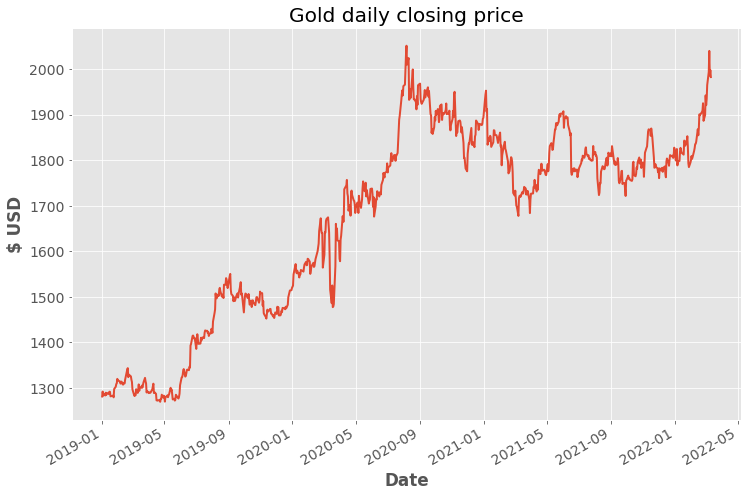

In [2]:
gold_df = yf.download('GC=F', 
                      start='2019-01-01', # YOU CAN CHANGE THIS
                      
                      end='2022-03-12', # DO NOT CHANGE THIS
                      progress=False)
gold_df['Close'].plot(title="Gold daily closing price", figsize=(12,8),ylabel='$ USD')
gold_df

### Evaluation

Following in the footsteps of the [M4 time series competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), submissions will be evaluated based on the average of two metrics:
1. Symmetric mean absolute percentage error (MAPE)

$$\text{sMAPE}=\frac{2}{h}\sum_{t=n+1}^{n+h}\frac{|y_t-\hat{y_t}|}{|y_t|+|\hat{y_t}|}*100(\%)$$

2. Mean absolute scaled error (MASE)

$$\text{MASE}=\frac{1}{h}\frac{\sum_{t=n+1}^{n+h}|y_t-\hat{y_t}|}{\frac{1}{n-1}\sum_{t=2}^{n}|y_t-y_{t-1}|}$$

Where $y_t$ is the value of the series at time $t$, $\hat{y_t}$ is the forecast at time $t$, $h$ is the forecast horizon, $n$ is the number of training samples.

### Grading

Accuracy: 30%
Reasoning: 60%
Visualizations: 10%

In addition, I will also build my own model and submit it by Saturday. I am not gonna be able to see the test set until March 19th so I have no control over how the results will look like. If your model can beat mine, you get 5% bonus points

### Prizes

Based on accuracy

- **1st**: 100% on Lab 1, Lab 2, and Lab 3.
- **2nd**: 100% on Lab 1, Lab 2, and Lab 3.
- **3rd**: 100% on Lab 3.


## Your Code Goes Here
<hr>

<br><br><br>

In [3]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [4]:
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

Df = gold_df.copy()

Df = Df.reset_index()
Df['Year'] = Df['Date'].apply(lambda time: time.year)
Df['Month'] = Df['Date'].apply(lambda time: time.month)
Df['Day'] = Df['Date'].apply(lambda time: time.day)
Df["High_Low"] = Df["High"] - Df["Low"]
Df["Open_High"] = Df["Open"] - Df["High"]
Df["Low_Open"] = Df["Low"] - Df["Open"]
Df = Df.set_index('Date')

Df['S_2'] = Df['Close'].rolling(window=2).mean()
Df['S_7'] = Df['Close'].rolling(window=7).mean()
Df['S_14'] = Df['Close'].rolling(window=14).mean()
Df['next_day_price'] = Df['Close'].shift(-1)
Df = Df.dropna()

In [6]:
X = Df[["High_Low", "Open_High", "Low_Open",'S_2', 'S_7', 'S_14', 'Year', 'Month', 'Day']]
y = Df['next_day_price']

t = .8
t = int(t*len(Df))
# Train dataset
X_train = X[:t]
y_train = y[:t]
# Test dataset
X_test = X[t:]
y_test = y[t:]

## Lasso Model

In [7]:
model = Lasso(alpha = 15)
model_fit = model.fit(X_train, y_train)
predicted_price = model_fit.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])

**Scores**

In [8]:
smape(pd.DataFrame(y_test)['next_day_price'], predicted_price['price'])

0.7421228779528914

In [9]:
MASE(pd.DataFrame(y_train)['next_day_price'], pd.DataFrame(y_test)['next_day_price'], predicted_price['price'])

1.113608179120353

**Function to calculate future values using recursive method**

In [10]:
def recursive_forecast(input_data, model, n=20, responses=1):
    forecast = np.empty((n, responses))  # where we'll store our forecasts
    for i, n in enumerate(range(n)):     # loop for making forecasts one at a time
        forecast[i] = model.predict(input_data.reshape(1, -1))  # model forecast
        input_data = np.append(forecast[i], input_data[:-responses])  # append forecast to input data for next forecast
    return forecast.reshape((-1, responses))

In [11]:
def create_forecast_index(start, horizon=30, freq="D"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")

In [12]:
Df_2 = Df[["High_Low", "Open_High", "Low_Open",'S_2', 'S_7', 'S_14', 'Year', 'Month', 'Day']]

# Forecast variables
forecast_index = create_forecast_index(Df_2.index[-1], 8)
# Recursive forecast
last_observations = Df_2.iloc[-1, :].to_numpy()
recursive = pd.DataFrame({"Close": recursive_forecast(last_observations, model, n=len(forecast_index)).ravel(),
                          "Label": "Recursive"},
                          index=forecast_index)

**Forecasted values**

In [13]:
gold_predictions = recursive[['Close']].tail(5)
gold_predictions

,Close
Time,
2022-03-14,526.364002
2022-03-15,2269.322988
2022-03-16,-356.231952
2022-03-17,-1456.482547
2022-03-18,1223.472439


<br><br>

## FB Prophet

**Model**

pip install prophet

In [14]:
from prophet import Prophet

m = Prophet(interval_width=0.95)

data = Df.reset_index()
data = data[['Date', 'Close']].rename(columns = {'Date': 'ds', 'Close': 'y'})
m.fit(data)
future = m.make_future_dataframe(periods=8)
forecast = m.predict(future) 
forecast_df = forecast[['ds', 'yhat']].rename(columns = {'ds': 'Date', 'yhat': 'Close'})
gold_predictions = forecast_df.tail(5)
gold_predictions

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.47109
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2643.02     0.0373585       429.821           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2684.79     0.0100415       240.463           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2699.27    0.00569618        229.98           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2702.83   0.000513515       210.669      0.3529           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     481       2705.27   7.90593e-05       225.192   1.228e-07       0.001      622  LS failed, Hessian reset 
     499       2706.25   0.000750069    

,Date,Close
795,2022-03-14,1876.771732
796,2022-03-15,1875.605990
797,2022-03-16,1873.521995
798,2022-03-17,1871.970748
799,2022-03-18,1868.759533


**Scores**

In [15]:
interim_forecast = forecast_df[(forecast_df['Date'] > '2021-07-26') & (forecast_df['Date'] < '2022-03-11')]

smape(interim_forecast['Close'], predicted_price['price'])

0.0

In [16]:
MASE(interim_forecast['Close'], pd.DataFrame(y_test)['next_day_price'], predicted_price['price'])

6.257738705946863